## Intensity simulations

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from pyro.ops.stats import hpdi, quantile
from pyro.infer import Predictive
import pyro.distributions as dist

from tapqir.models import Cosmos

### Load results

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [3]:
D = 14
background = 150
gain = torch.tensor(7.)
width = torch.tensor([1.4])
rv = dist.MultivariateNormal(
    torch.tensor([(D-1)/2, (D-1)/2]),
    scale_tril=torch.eye(2) * width[..., None, None])

D_range = torch.arange(D, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

In [4]:
truth = {}
fit = {}
predictions = defaultdict(dict)
models = {}
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("height"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "global_params.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["height"] = truth[data_path.name]["height"]
        
        models[data_path.name] = Cosmos()
        models[data_path.name].load(data_path, True, "cpu")
        models[data_path.name].load_parameters(param_path)
        
        # calculate ci
        mask = torch.from_numpy(models[data_path.name].data.labels["z"])
        samples = torch.masked_select(models[data_path.name].z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = models[data_path.name].z_marginal.flatten()
        low, high = hpdi(samples, 0.68)
        median = quantile(samples, 0.5)
        fit[data_path.name]["median"] = median.item()
        fit[data_path.name]["low"] = low.item()
        fit[data_path.name]["high"] = high.item()
        
        # calculate snr
        weights = rv.log_prob(ij_pixel).exp()
        signal = (weights ** 2 * truth[data_path.name]["height"]).sum()
        noise = ((background) * gain).sqrt()
        truth[data_path.name]["snr"] = float(signal / noise)

In [5]:
truth_df = pd.concat(truth.values(), axis=1).T
truth_df = truth_df.sort_values(by="height")
truth_df

,gain,probs_z,rate_j,proximity,offset,height,background,snr
height300,7.0,0.15,0.15,0.2,90.0,300.0,150.0,0.375890
height500,7.0,0.15,0.15,0.2,90.0,500.0,150.0,0.626483
height600,7.0,0.15,0.15,0.2,90.0,600.0,150.0,0.751780
height750,7.0,0.15,0.15,0.2,90.0,750.0,150.0,0.939725
height1000,7.0,0.15,0.15,0.2,90.0,1000.0,150.0,1.252966
height1500,7.0,0.15,0.15,0.2,90.0,1500.0,150.0,1.879450
height2000,7.0,0.15,0.15,0.2,90.0,2000.0,150.0,2.505933
height3000,7.0,0.15,0.15,0.2,90.0,3000.0,150.0,3.758900


In [6]:
fit_df = pd.concat(fit.values(), axis=1).T
fit_df = fit_df.sort_values(by="height").drop(
    ["width_mean_0", "width_size_0", "height_scale", "height"],
    axis=1
)
fit_df

,-ELBO,proximity_0,gain,probs_z_0,probs_z_1,rate_j,MCC,Recall,Precision,FN,TP,TN,FP,median,low,high
height300,4833945.5,0.155404,7.052951,0.999984,0.000016,1.604455e-07,0.000000,0.000000,0.000000,383.0,0.0,2117.0,0.0,0.000105,0.000061,0.000168
height500,4823387.0,0.210942,7.082563,0.975732,0.024268,4.904570e-05,0.348376,0.143603,0.982143,328.0,55.0,2116.0,1.0,0.025636,0.000083,0.095273
height600,4816250.0,0.265640,7.094440,0.941537,0.058463,2.236452e-03,0.561831,0.368146,0.965753,242.0,141.0,2112.0,5.0,0.227865,0.000082,0.590299
height750,4812807.0,0.271114,7.069738,0.887020,0.112980,1.795804e-02,0.803128,0.715405,0.958042,109.0,274.0,2105.0,12.0,0.944875,0.583767,0.999209
height1000,6644535.5,0.284495,7.112312,0.841972,0.158028,2.958565e-02,0.957841,0.984334,0.944862,6.0,377.0,2095.0,22.0,0.992440,0.991840,0.993170
height1500,4815398.5,0.226648,7.039655,0.847183,0.152817,1.288471e-01,0.979981,0.984334,0.981771,6.0,377.0,2110.0,7.0,0.995111,0.994261,0.996052
height2000,4820185.0,0.217597,7.029237,0.846243,0.153757,1.372369e-01,0.983025,0.984334,0.986911,6.0,377.0,2112.0,5.0,0.995029,0.993988,0.995983
height3000,4831345.0,0.208446,7.012884,0.846592,0.153408,1.394771e-01,0.989198,0.989556,0.992147,4.0,379.0,2114.0,3.0,0.996512,0.995493,0.998089


### Figure 4

In [11]:
np.arange(0, 1.05, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

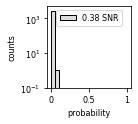

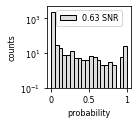

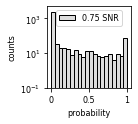

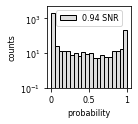

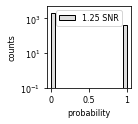

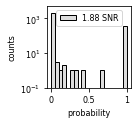

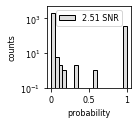

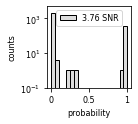

In [28]:
for name in fit_df.index:
    plt.figure(figsize=(1.5, 1.5))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    plt.yscale("log")
    plt.xlim(-0.05,1.05)
    plt.ylim(1e-1, 5e3)
    plt.xticks([0, 0.5, 1], fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel("counts", fontsize=8)
    plt.xlabel("probability", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/tmp/snr-logdensity{name}.svg")
    plt.show()

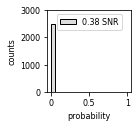

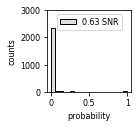

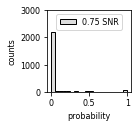

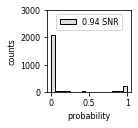

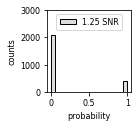

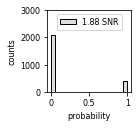

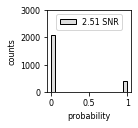

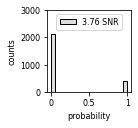

In [29]:
for name in fit_df.index:
    plt.figure(figsize=(1.5, 1.5))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    plt.xlim(-0.05,1.05)
    plt.ylim(0, 3000)
    plt.xticks([0, 0.5, 1], fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel("counts", fontsize=8)
    plt.xlabel("probability", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/tmp/snr-density{name}.svg")
    plt.show()

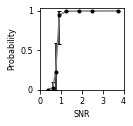

In [28]:
plt.figure(figsize=(1.5, 1.5))
plt.errorbar(truth_df["snr"], fit_df["median"],
             yerr=abs(fit_df[["low", "high"]].values.T-fit_df["median"].values),
             fmt="o-", ms=3, color="C7", mfc="k", mec="k", ecolor="k", capsize=2)
plt.xlim(0, 4)
plt.ylim(0, 1.03)
plt.xticks([0, 1, 2, 3, 4], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("SNR", fontsize=8)
plt.ylabel("Probability", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.savefig("/tmp/snr-errorbar.svg")
plt.show()

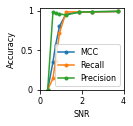

In [29]:
plt.figure(figsize=(1.5, 1.5))
plt.plot(truth_df["snr"], fit_df["MCC"], "o-", ms=3, label="MCC")
plt.plot(truth_df["snr"], fit_df["Recall"], "o-", ms=3, label="Recall")
plt.plot(truth_df["snr"], fit_df["Precision"], "o-", ms=3, label="Precision")
plt.xlim(0, 4)
plt.ylim(0, 1.03)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("SNR", fontsize=8)
plt.ylabel("Accuracy", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.legend(fontsize=8)
plt.savefig("/tmp/snr-mcc.svg")
plt.show()

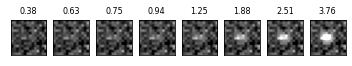

In [30]:
plt.figure(figsize=(6,3))
for i, name in enumerate(truth_df.index):
    plt.subplot(1, len(truth_df), i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"{truth_df.loc[name, 'snr']:.2f}", fontsize=8)
    plt.imshow(models[name].data[0, 1].numpy(), vmin=190, vmax=380, cmap="gray")
plt.savefig("/tmp/snr-images.png", dpi=600)
plt.show()

### Figure 5

In [30]:
data_path = EXAMLES_DIR / "height3000"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)
#model.n = None
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)
samples = predictive()

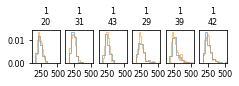

In [31]:
aois = [1, 1, 1, 1, 1, 1]
frames = [20, 31, 43, 29, 39, 42]

plt.figure(figsize=(3.5, 0.6))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.title(f"{n}\n{f}", fontsize=8)
    plt.hist(
        model.data[n, f].flatten().numpy(),
        range=(model.data.vmin-20, model.data.vmax+150),
        density=True, bins=10, histtype="step", lw=0.5, label="data")
    plt.hist(
        samples["d/data"][0, n, f].flatten().numpy(),
        range=(model.data.vmin-10, model.data.vmax+150),
        density=True, bins=20, histtype="step", lw=0.5, label="posterior")
    plt.xlim(120, model.data.vmax+150)
    plt.xticks(fontsize=8)
    if i == 0:
        plt.yticks(fontsize=8)
    else:
        plt.yticks([])

# plt.tight_layout()
plt.savefig("/tmp/height-hist.svg")

plt.show()

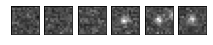

In [34]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(model.data[n, f].numpy(), vmin=120, vmax=model.data.vmax+150, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

plt.savefig("/tmp/height-data.png", dpi=600)

plt.show()

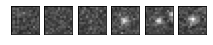

In [35]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.imshow(samples["d/data"][0, n, f].numpy(), vmin=120, vmax=model.data.vmax+150, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.tight_layout()
plt.savefig("/tmp/height-sample.png", dpi=600)

plt.show()

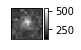

In [36]:
plt.figure(figsize=(0.7, 0.7))

plt.imshow(model.data[n, f].numpy(), vmin=120, vmax=model.data.vmax+150, cmap="gray")
plt.xticks([], [])
plt.yticks([], [])

plt.colorbar(aspect=7, shrink=0.8)
plt.savefig("/tmp/height-colorbar.svg")

plt.show()

### Analysis

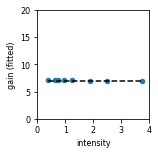

In [38]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["snr"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["snr"], fit_df["gain"], s=20)
plt.ylim(0, 20)
plt.xlim(0, 4)
plt.xticks([0, 1, 2, 3, 4], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"intensity", fontsize=8)
plt.ylabel(r"gain (fitted)", fontsize=8)
plt.show()

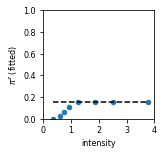

In [40]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["snr"].sort_values(), truth_df["probs_z"].sort_values(), "k--")
plt.scatter(truth_df["snr"], fit_df["probs_z_1"], s=20)
plt.ylim(0, 1)
plt.xlim(0, 4)
plt.xticks([0, 1, 2, 3, 4], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"intensity", fontsize=8)
plt.ylabel(r"$\pi^z$ (fitted)", fontsize=8)
plt.show()

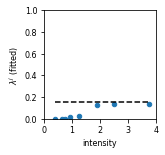

In [41]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["snr"].sort_values(), truth_df["rate_j"].sort_values(), "k--")
plt.scatter(truth_df["snr"], fit_df["rate_j"], s=20)
plt.ylim(0, 1.)
plt.xlim(0, 4)
plt.xticks([0, 1, 2, 3, 4], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"intensity", fontsize=8)
plt.ylabel(r"$\lambda^j$ (fitted)", fontsize=8)
plt.show()

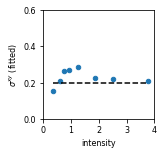

In [42]:
plt.figure(figsize=(2, 2))
plt.plot(truth_df["snr"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["snr"], fit_df["proximity_0"], s=20)
plt.ylim(0., 0.6)
plt.xlim(0, 4)
plt.xticks([0, 1, 2, 3, 4], fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r"intensity", fontsize=8)
plt.ylabel(r"$\sigma^{xy}$ (fitted)", fontsize=8)
plt.show()